# Import Necessary Libraries 

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from sklearn.metrics import precision_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

# Data Preprocessing 

In [50]:
#Connects to directory where cvs spreadsheets are sotred
os.chdir("c:/Users/Tani/Documents/CompSciProject/")
path = "c:/Users/Tani/Documents/CompSciProject/"
csv_files = glob.glob(path + "/*.csv")

In [51]:
#Reads in the spred sheets
df_list = (pd.read_csv(file) for file in csv_files)
matches1 =pd.read_csv('2020-2021.csv')
matches2 = pd.read_csv('2021-2022.csv')



In [52]:
#Gets a list of all the home teams
teams1 = matches1['HomeTeam'].tolist()
teams2 = matches2['HomeTeam'].tolist()

#ensures that there are no duplicates 
list_teams1 = list(set(teams1))
list_teams2 = list(set(teams2))


In [53]:
print(list_teams1)
print(list_teams2)

['West Ham', 'Liverpool', 'Arsenal', 'Everton', 'Aston Villa', 'Chelsea', 'Man City', 'Leeds', 'Newcastle', 'Brighton', 'Crystal Palace', 'Burnley', 'Fulham', 'Tottenham', 'Man United', 'Wolves', 'Leicester', 'Sheffield United', 'Southampton', 'West Brom']
['West Ham', 'Liverpool', 'Arsenal', 'Everton', 'Aston Villa', 'Chelsea', 'Man City', 'Leeds', 'Newcastle', 'Brighton', 'Watford', 'Crystal Palace', 'Burnley', 'Tottenham', 'Man United', 'Wolves', 'Leicester', 'Brentford', 'Southampton', 'Norwich']


In [54]:
#Drops uneccessary colummns from the dataframe 

colsToKeep = list(["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","Coded FTR","HTHG","HTAG","HTR","HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR"])
allcols = matches1.columns
colsToDrop = set(allcols) - set(colsToKeep)
matches1 = pd.DataFrame(matches1.drop(labels=colsToDrop,axis=1))
matches2 = pd.DataFrame(matches2.drop(labels=colsToDrop,axis=1))

In [55]:
# Define a custom function to calculate the goals conceded by the home team
def home_goals_conceded(row):
    return row['FTAG']

# Define a custom function to calculate the goals conceded by the away team
def away_goals_conceded(row):
    return row['FTHG']


# Apply the custom functions to each row of the DataFrame
matches1['HGC'] = matches1.apply(home_goals_conceded, axis=1)
matches1['AGC'] = matches1.apply(away_goals_conceded, axis=1)

matches2['HGC'] = matches2.apply(home_goals_conceded, axis=1)
matches2['AGC'] = matches2.apply(away_goals_conceded, axis=1)

In [56]:
def goal_difference(row):
    return (row['FTHG'] - row['FTAG'])


matches1['Goal Difference'] = matches1.apply(goal_difference, axis=1)
matches2['Goal Difference'] = matches2.apply(goal_difference, axis=1)

In [79]:
# Sort the list of teams alphabetically
sorted_teams1 = sorted(list_teams1)
sorted_teams2 = sorted(list_teams2)

# Create a new DataFrame with the sorted teams as the index
league_table1 = pd.DataFrame(index=sorted_teams1)
league_table2 = pd.DataFrame(index=sorted_teams2)


# Add columns for the points, wins, draws, losses, goals for, goals against, and goal difference
league_table1['Points'] = 0
league_table1['Wins'] = 0
league_table1['Draws'] = 0
league_table1['Losses'] = 0
league_table1['Goals For'] = 0
league_table1['Goals Against'] = 0

league_table2['Points'] = 0
league_table2['Wins'] = 0
league_table2['Draws'] = 0
league_table2['Losses'] = 0
league_table2['Goals For'] = 0
league_table2['Goals Against'] = 0


# Define a function to calculate the current position of each team in the league table
def calculate_position(row,league_table):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    # Update the league table based on the result of the match
    if home_goals > away_goals:
        league_table.loc[home_team, 'Points'] += 3
        league_table.loc[home_team, 'Wins'] += 1
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Goals Against'] += away_goals
        league_table.loc[away_team, 'Losses'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
    elif home_goals < away_goals:
        league_table.loc[away_team, 'Points'] += 3
        league_table.loc[away_team, 'Wins'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Losses'] += 1
        league_table.loc[home_team, 'Goals Against'] += away_goals
    else:
        league_table.loc[home_team, 'Points'] += 1
        league_table.loc[home_team, 'Draws'] += 1
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Goals Against'] += away_goals
        league_table.loc[away_team, 'Points'] += 1
        league_table.loc[away_team, 'Draws'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
    
    league_table['Goal Difference'] = league_table['Goals For'] - league_table['Goals Against']
    league_table = league_table.sort_values(['Points'] ,ascending=[False])
    league_table['Position'] = range(1, len(league_table) + 1)
    home_pos = league_table.loc[home_team, 'Position']
    away_pos = league_table.loc[away_team, 'Position']
    
    home_pos = league_table.loc[home_team, 'Position']
    away_pos = league_table.loc[away_team, 'Position']
    
    return home_pos - away_pos

    # Return the position of each team in the league table
    #return ((league_table.loc[home_team,'Position'] - league_table.loc[away_team,'Position']))
    


# Apply the function to each row of the matches data frame and create two new columns with the results
matches1['League Table Difference'] = matches1.apply(lambda row: calculate_position(row, league_table1), axis=1)
matches2['League Table Difference'] = matches2.apply(lambda row: calculate_position(row, league_table2), axis=1)

In [58]:
#Function to group the  matches into rolling averages
def rolling_averages(group,cols,new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5,closed = 'left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    
    return group

In [59]:
#Create the rolling features columns 
cols = ["FTHG","FTAG","HTHG","HTAG","Coded FTR","HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR","HGC","AGC"]
new_cols = [f"{c}_rolling" for c in cols]
print(new_cols)

['FTHG_rolling', 'FTAG_rolling', 'HTHG_rolling', 'HTAG_rolling', 'Coded FTR_rolling', 'HS_rolling', 'AS_rolling', 'HST_rolling', 'AST_rolling', 'HC_rolling', 'AC_rolling', 'HF_rolling', 'AF_rolling', 'HY_rolling', 'AY_rolling', 'HR_rolling', 'AR_rolling', 'HGC_rolling', 'AGC_rolling']


In [60]:
#Applying the rolling averaes function to each of the dataframes 
matches1_rolling = matches1.groupby("HomeTeam").apply(lambda x: rolling_averages(x,cols,new_cols))
matches2_rolling = matches2.groupby("HomeTeam").apply(lambda x: rolling_averages(x,cols,new_cols))

print(matches1_rolling)




             Div        Date HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  \
HomeTeam                                                                      
Arsenal  178  E0  18/01/2021  Arsenal       Newcastle     3     0   H     0   
         313  E0  18/04/2021  Arsenal          Fulham     1     1   D     0   
         11   E0  19/09/2020  Arsenal        West Ham     2     1   H     1   
         244  E0  21/02/2021  Arsenal        Man City     0     1   A     0   
         320  E0  23/04/2021  Arsenal         Everton     0     1   A     0   
...           ..         ...      ...             ...   ...   ...  ..   ...   
Wolves   58   E0  30/10/2020   Wolves  Crystal Palace     2     0   H     2   
         35   E0   4/10/2020   Wolves          Fulham     1     0   H     0   
         299  E0    5/4/2021   Wolves        West Ham     2     3   A     1   
         221  E0    7/2/2021   Wolves       Leicester     0     0   D     0   
         342  E0    9/5/2021   Wolves        Brighto

In [61]:
#Concatenating both of the dataframes into one single frame 
matches_concat = pd.concat([matches1_rolling,matches2_rolling], ignore_index=True)

In [62]:

# Total number of matches.
n_matches = matches_concat.shape[0]

#Matches won by home team
n_homewins = len(matches_concat[matches_concat.FTR == 'H'])

#percentage of matches won by home team
win_rate = (float(n_homewins) / (n_matches)) * 100

print ("Total number of matches: {}".format(n_matches))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 560
Number of matches won by home team: 225
Win rate of home team: 40.18%


In [78]:
# Reset the index of matches_concat

home_stats = matches_concat.groupby('HomeTeam')[['FTHG', 'HTHG', 'HS', 'HST', 'HC', 'HF', 'HY', 'HR','HGC']].mean()

# Rename the columns to make them more descriptive
home_stats = home_stats.rename(columns={'FTHG': 'Average Home Goals Scored', 'HTHG': 'Average Home Half-time Goals Scored', 
                                        'HS': 'Average Home Shots', 'HST': 'Average Home Shots on Target', 'HC': 'Average Home Corners', 
                                        'HF': 'Average Home Fouls', 'HY': 'Average Home Yellow Cards', 'HR': 'Average Home Red Cards','HGC':'Average Home goals Conceded'})

# Group the data by away team and calculate the mean of the away statistics columns
away_stats = matches_concat.groupby('AwayTeam')[['FTAG', 'HTAG', 'AS', 'AST', 'AC', 'AF', 'AY', 'AR','AGC']].mean()

# Rename the columns to make them more descriptive
away_stats = away_stats.rename(columns={'FTAG': 'Average Away Goals Scored', 'HTAG': 'Average Away Half-time Goals Scored', 
                                        'AS': 'Average Away Shots', 'AST': 'Average Away Shots on Target', 'AC': 'Average Away Corners', 
                                        'AF': 'Average Away Fouls', 'AY': 'Average Away Yellow Cards', 'AR': 'Average Away Red Cards','AGC':'Average Away goals Conceded'})



# Random Forest Classifier 

In [64]:
#Splitting the dataset into training and testing sets for the decsion forest 
train = matches_concat[matches_concat["Date"] < "2021-01-01"]
test = matches_concat[matches_concat["Date"] > "2021-01-01"]

In [65]:
#Setting the hyper parameters for the decision forest
rf = RandomForestClassifier(n_estimators = 57, min_samples_split = 35, random_state = 22)

In [66]:
#Setting the predictors and the target
predictors = ['Coded FTR_rolling',
                    'HS_rolling', 'AS_rolling', 'AC_rolling',
                    'League Table Difference']
target = ["Coded FTR"]

In [67]:
#Training the decision forest 
rf.fit(train[predictors],train[target])

C:\Users\Tani\AppData\Local\Temp\ipykernel_2396\3326233647.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train[predictors],train[target])


RandomForestClassifier(min_samples_split=35, n_estimators=57, random_state=22)

In [68]:
#putting te predictions into a variable 
preds = rf.predict(test[predictors])

#getting accuarcy 
decsion_forest_accuracy = accuracy_score(test[target], preds)

print (decsion_forest_accuracy)

0.55


In [69]:
decsion_forest_f1_score = f1_score(test[target], preds,average = 'macro')
print(decsion_forest_f1_score)

0.4232379719761498


In [70]:
#Flattening the values to load into a crosstab ()
#actual_flat = test[target].values.flatten()
#preds_flat = preds.flatten()
#combined = pd.DataFrame({'actual': actual_flat, 'predicted': preds_flat})

#pd.crosstab(index=combined["actual"], columns=combined["predicted"])

In [71]:
decsion_forest_precision = precision_score(test[target],preds, average='macro')

decsion_forest_precision

0.40826723611958515

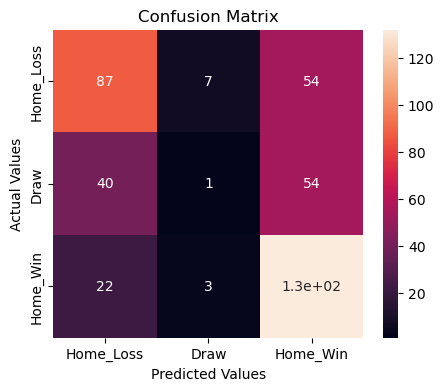

In [72]:
# Filling the confusion matrix with the predicted test values and the targets
cm1 = confusion_matrix(test[target].values,preds)

cm_df1 = pd.DataFrame(cm1,
                     index=['Home_Loss', 'Draw', 'Home_Win'],
                     columns=['Home_Loss', 'Draw', 'Home_Win'])

#Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df1, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Splitting data into target/features and training and testing for SVMs and XgBoost

In [18]:
#Making a dataframe that consits of just the predicting factors
features = matches_concat[['FTHG_rolling', 'FTAG_rolling', 'HTHG_rolling', 'HTAG_rolling', 'Coded FTR_rolling',
                    'HS_rolling', 'AS_rolling', 'HST_rolling', 'AST_rolling', 'HC_rolling', 'AC_rolling',
                    'HY_rolling', 'AY_rolling','HR_rolling','AR_rolling', 'HGC_rolling', 'AGC_rolling','League Table Difference']]

# instantiate the StandardScaler
#scaler = StandardScaler()
#features = scaler.fit_transform(features)
print (features)

     FTHG_rolling  FTAG_rolling  HTHG_rolling  HTAG_rolling  \
0             1.4           1.0           0.8           0.4   
1             2.0           0.8           0.8           0.4   
2             2.2           1.0           0.8           0.4   
3             1.8           0.8           0.4           0.6   
4             1.4           0.8           0.2           0.6   
..            ...           ...           ...           ...   
555           1.4           0.6           0.8           0.4   
556           1.4           0.8           0.8           0.6   
557           1.0           0.8           0.6           0.4   
558           0.6           1.2           0.2           0.6   
559           0.2           1.2           0.0           0.4   

     Coded FTR_rolling  HS_rolling  AS_rolling  HST_rolling  AST_rolling  \
0                  0.2        12.8        10.0          4.4          3.0   
1                  0.6        13.2         8.8          4.4          2.8   
2              

In [19]:
#putting the fetures and target into a numpy array
Match_features = np.array(features)
print(Match_features)

target = np.array(matches_concat[["Coded FTR"]])

[[ 1.4  1.   0.8 ...  1.4 10.  15. ]
 [ 2.   0.8  0.8 ...  2.   9.  18. ]
 [ 2.2  1.   0.8 ...  2.2  1.  20. ]
 ...
 [ 1.   0.8  0.6 ...  1.   8.   9. ]
 [ 0.6  1.2  0.2 ...  0.6  8.   1. ]
 [ 0.2  1.2  0.  ...  0.2  8.  10. ]]


In [20]:
#Splitting the data into testing and training sets
X_train, X_val,\
    Y_train, Y_val = train_test_split(Match_features, target,
                                      test_size=0.2,random_state = 22)
  
X_train.shape, X_val.shape

((448, 19), (112, 19))

# SVM Classifier linear

In [21]:
#Splitting the data into testing and training sets
X_train, X_val,\
    Y_train, Y_val = train_test_split(Match_features, target,
                                      test_size=0.2,random_state = 22)
  
X_train.shape, X_val.shape

((448, 19), (112, 19))

In [22]:
#Create a svm Classifier
clf = SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
#Evaluate Linear SVM
from sklearn import metrics

svm1_accuracy = metrics.accuracy_score(Y_val, y_pred)

print("Accuracy:",svm1_accuracy)

svm1_f1_score = f1_score(Y_val, y_pred,average = 'macro')


print("F1_Score:",svm1_f1_score)

svm1_precision = metrics.precision_score(Y_val, y_pred, average='macro')

print("Precision:",svm1_precision)

Accuracy: 0.6339285714285714
F1_Score: 0.5365237104707751
Precision: 0.5608974358974359


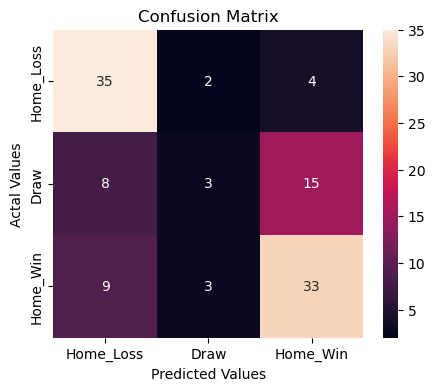

In [24]:
#Filling the confusion matrix with the predicted test values and the targets
cm2 = confusion_matrix(Y_val, y_pred)

cm_df2 = pd.DataFrame(cm2,
                     index = ['Home_Loss','Draw','Home_Win'], 
                     columns = ['Home_Loss','Draw','Home_Win'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# SVM Classifier Sigmoid

In [25]:
#Create a svm Classifier
clf2 = SVC(kernel='sigmoid') # Linear Kernel

#Train the model using the training sets
clf2.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf2.predict(X_val)

C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
#Evaluate Sigmoid SVM

svm2_accuracy = metrics.accuracy_score(Y_val, y_pred)

print("Accuracy:",svm2_accuracy)

svm2_f1_score = f1_score(Y_val, y_pred,average = 'macro')


print("F1_Score:",svm2_f1_score)

svm2_precision = metrics.precision_score(Y_val, y_pred, average='macro')

print("Precision:",svm2_precision)


Accuracy: 0.5446428571428571
F1_Score: 0.41074829931972784
Precision: 0.363820488220872


C:\Users\Tani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


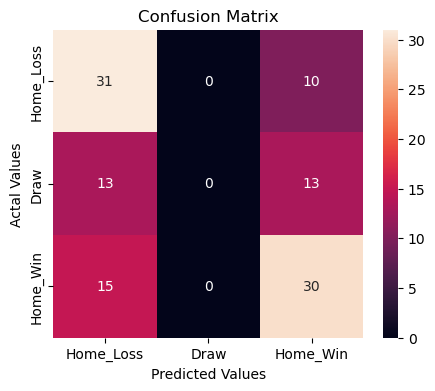

In [27]:
#Filling the confusion matrix with the predicted test values and the targets
cm3 = confusion_matrix(Y_val,y_pred)

cm_df3 = pd.DataFrame(cm3,
                     index = ['Home_Loss','Draw','Home_Win'], 
                     columns = ['Home_Loss','Draw','Home_Win'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df3, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# SVM Classifier Polynomial

In [28]:
#Create a svm Classifier
clf3 = SVC(kernel='poly') # Linear Kernel

#Train the model using the training sets
clf3.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf3.predict(X_val)

C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
#Evaluate Polynomial SVM
svm3_accuracy = metrics.accuracy_score(Y_val, y_pred)

print("Accuracy:",svm3_accuracy)

svm3_f1_score = f1_score(Y_val, y_pred,average = 'macro')


print("F1_Score:",svm3_f1_score)


svm3_precision = metrics.precision_score(Y_val, y_pred, average='macro')

print("Precision:",svm3_precision)


Accuracy: 0.5892857142857143
F1_Score: 0.4698566888529112
Precision: 0.49053030303030304


[ 1 -1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1
 -1  1 -1 -1  1 -1  1  1  1  1  0 -1  1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1  1 -1  0  1  1  1  0  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1
  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1  0  1 -1 -1
  1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1  1  1  1]


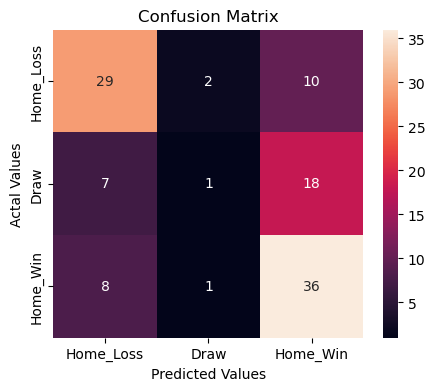

In [30]:
#Filling the confusion matrix with the predicted test values and the targets
print(y_pred)
confusion_matrix = confusion_matrix(Y_val, y_pred)

cm_df = pd.DataFrame(confusion_matrix,
                     index = ['Home_Loss','Draw','Home_Win'], 
                     columns = ['Home_Loss','Draw','Home_Win'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# XgBoost Classifier 

In [31]:
#Splitting the data into testing and training sets
X_train, X_val,\
    Y_train, Y_val = train_test_split(Match_features, target,
                                      test_size=0.2,random_state = 22)
  
X_train.shape, X_val.shape

((448, 19), (112, 19))

In [32]:
#Initialising XgBoost Model
xgboostmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

C:\Users\Tani\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [33]:
#Adding 1 to Y_train and Y_val becuase for some reason xgboost only classifies into 0,1 and 2
Y_train = Y_train+1
Y_val = Y_val+1
xgboostmodel.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [34]:
y_pred = xgboostmodel.predict(X_val)

In [45]:
#Evaluate XgBoost
xgboost_accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (xgboost_accuracy * 100.0))


xgboost_f1_score = f1_score(Y_val, y_pred,average = 'macro')
print("F1_Score:", xgboost_f1_score)

xgboost_precision = metrics.precision_score(Y_val, y_pred, average='macro')
print("Precsion:",xgboost_precision)

Accuracy: 54.46%
F1_Score: 0.5038884689678341
Precsion: 0.5094422376696458


[2 0 0 2 0 1 2 1 2 1 0 2 2 0 1 0 1 0 2 2 1 2 0 2 1 2 0 0 2 2 0 2 2 2 1 0 2
 2 2 1 0 1 2 0 2 2 0 0 2 2 0 0 2 2 2 2 1 2 2 0 2 2 0 0 0 2 0 2 0 2 1 2 1 2
 0 2 2 2 0 0 0 1 0 2 0 2 0 2 0 2 0 1 1 0 1 0 2 0 2 0 2 0 1 2 2 2 2 0 0 2 1
 2]


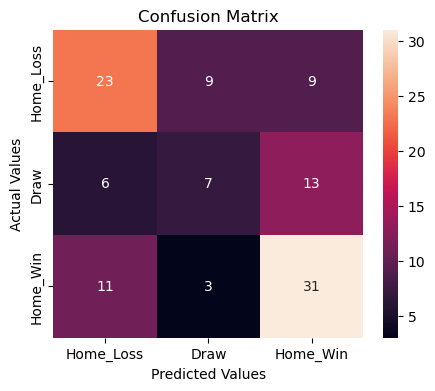

In [48]:
from sklearn.metrics import confusion_matrix as cm

conf_matrix = cm(Y_val, y_pred)

conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['Home_Loss', 'Draw', 'Home_Win'],
                              columns=['Home_Loss', 'Draw', 'Home_Win'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Bar Charts

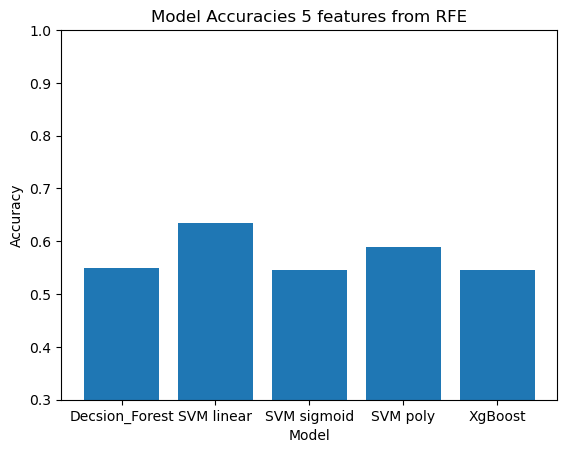

In [73]:
Accuracy = [decsion_forest_accuracy,svm1_accuracy,svm2_accuracy,svm3_accuracy,xgboost_accuracy]
Models = ["Decsion_Forest","SVM linear","SVM sigmoid","SVM poly","XgBoost"]


plt.bar(Models, Accuracy)
plt.title('Model Accuracies 5 features from RFE')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.3,1)
plt.show()

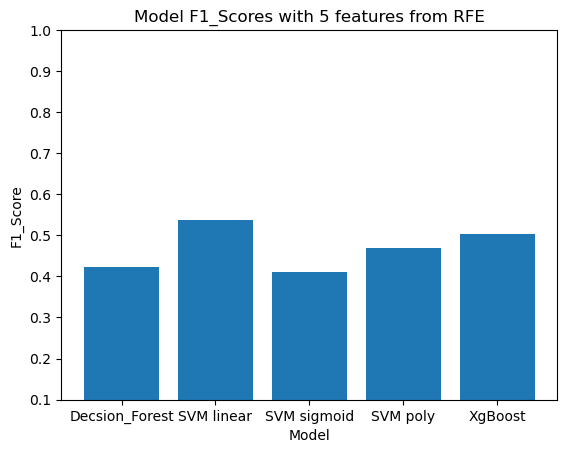

In [74]:
f1_Scores = [decsion_forest_f1_score,svm1_f1_score,svm2_f1_score,svm3_f1_score,xgboost_f1_score]
Models = ["Decsion_Forest","SVM linear","SVM sigmoid","SVM poly","XgBoost"]


plt.bar(Models, f1_Scores)
plt.title('Model F1_Scores with 5 features from RFE')
plt.xlabel('Model')
plt.ylabel('F1_Score')
plt.ylim(0.1,1)
plt.show()

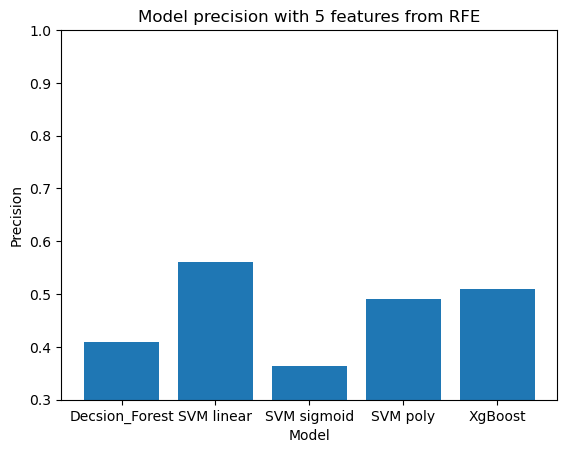

In [75]:
precision = [decsion_forest_precision,svm1_precision,svm2_precision,svm3_precision,xgboost_precision]
Models = ["Decsion_Forest","SVM linear","SVM sigmoid","SVM poly","XgBoost"]


plt.bar(Models, precision)
plt.title('Model precision with 5 features from RFE')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.3,1)
plt.show()

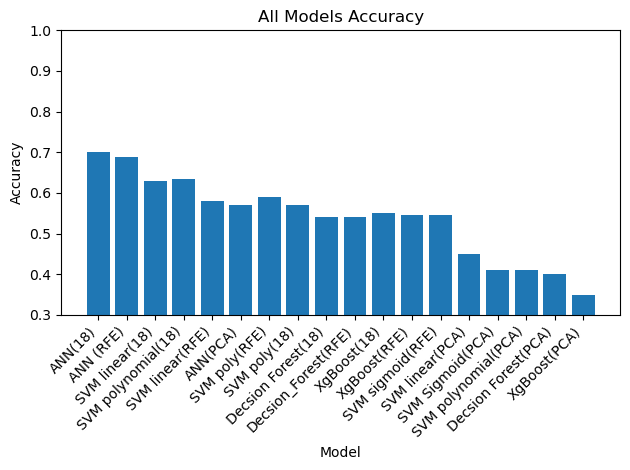

In [77]:
Accuracy = [0.7, 0.688,0.63,svm1_accuracy,0.58,0.57,svm3_accuracy,0.57,0.54,0.54,0.54,decsion_forest_accuracy, xgboost_accuracy , svm2_accuracy,0.45,0.41,0.41,0.4,0.35]
Models = ["ANN(18)", "ANN (RFE)","SVM linear(18)","SVM polynomial(18)","SVM linear(RFE)","ANN(PCA)", 
          "SVM poly(RFE)","SVM poly(18)","SVM poly(18)","Decsion Forest(18)","Decsion_Forest(RFE)","XgBoost(18)", "XgBoost(RFE)", 
          "SVM sigmoid(RFE)","SVM linear(PCA)","SVM Sigmoid(PCA)","SVM polynomial(PCA)","Decsion Forest(PCA)","XgBoost(PCA)"]

plt.bar(Models, Accuracy)
plt.title('All Models Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.3, 1)

plt.xticks(rotation=45, ha='right')  # rotate x-labels by 45 degrees
plt.tight_layout()  # adjust the layout

plt.show()